In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import KetSugar as ks
import WaveplateBox as wp
import HammerProj as hp

DEG = np.pi/180.
SAMPLING = int(360*16)

def GenerateCurve(ket, delta=0):    
    #alphas = np.linspace(0, np.pi*2*rots, 720*rots + 1)    
    alphas = np.linspace(0, np.pi*2, SAMPLING + 1)    
    Is = [np.abs((wp.WP(alpha, np.pi/2 + delta) @ ket)[0,0])**2 for alpha in alphas]
    return alphas, Is

def ExtractStokesGoldstein(x, y):
    n = len(y)
    A = np.sum(y)*2/n
    B = -(np.sin(2*x) @ y)*4/n
    C = (np.cos(4*x) @ y)*4/n
    D = (np.sin(4*x) @ y)*(4/n)
    S0 = A - C
    S1 = 2*C
    S2 = 2*D
    S3 = B
    return A, B, C, D, S0, S1, S2, S3


def ExtractStokes(x, y, deltaerr):
    #https://doi.org/10.1364/AO.38.006508
    dx = x[1] - x[0]
    delta = deltaerr + np.pi/2
    A = np.sum(y)*dx/np.pi
    #B = -(np.sin(2*x) @ y)*2*dx/np.pi
    B = (np.sin(2*x) @ y)*2*dx/np.pi
    C = (np.cos(4*x) @ y)*2*dx/np.pi
    D = (np.sin(4*x) @ y)*2*dx/np.pi
    S0 = A-C/(np.tan(delta/2)**2)
    S1 = 2*C/(2*(np.sin(delta/2)**2))
    S2 = 2*D/(2*(np.sin(delta/2)**2))
    S3 = -B/(np.sin(delta)) #B/(np.sin(delta)**2)
    DOP = np.sqrt(S1**2 + S2**2 + S3**2)/S0
    return A, B, C, D, S0, S1, S2, S3, DOP

def get_cost_function(tomograms):
    # def cost_function(delta_gamma):
    #     s0_array = np.array([ExtractStokes(x, y, delta_gamma)[4] for x, y in tomograms])
    #     return np.ptp(s0_array)
    def cost_function(delta_gamma):
        s0_array = np.array([ExtractStokes(x, y, delta_gamma)[4] for x, y in tomograms])
        slen_array = np.array([ExtractStokes(x, y, delta_gamma)[-1] for x, y in tomograms])
        nsledarr = slen_array/s0_array
        #return np.ptp(slen_array) #np.ptp(slen_array/s0_array)    
        return np.ptp(slen_array)    
    return cost_function        

def hammer_map(rho):
    return hp.Hammer(*hp.BlochToGeo(*hp.RhoToBloch2(rho)), wrapback=True)

def stokes_to_bloch(x, y, z):
    norm = np.sqrt(x**2 + y**2 + z**2)
    phi = np.angle(1j*z + y)
    theta = np.arccos(x/norm)
    return theta, phi

def hammer_stokes(stokes):
    return hp.Hammer(*hp.BlochToGeo(*stokes_to_bloch(*stokes)), True)

In [5]:
for ket in [ks.LO, ks.HI, ks.HLO, ks.HHI, ks.CLO, ks.CHI]:
    x, y = GenerateCurve(ket, 10*DEG)
    A, B, C, D, S0, S1, S2, S3, DOP = np.array(ExtractStokes(x, y, 0*DEG))
    print(f'{S0:0.3f}\t{S1:0.3f}\t{S2:0.3f}\t{S3:0.3f}\t{DOP:0.3f}')

0.826	1.175	-0.000	0.000	1.423
1.174	-1.174	0.000	-0.000	1.000
1.000	0.001	1.174	-0.000	1.174
1.000	0.001	-1.174	0.000	1.174
1.000	0.001	-0.000	0.985	0.985
1.000	0.001	-0.000	-0.985	0.985


In [7]:
#Generate/simulate data
probe_coords = np.load('probes_samplings.npz')['n8']
probes = [ks.BlochKet(*coord) for coord in probe_coords]
#references = [ks.LO, ks.HI, ks.CLO, ks.HLO, ks.CLO, ks.CHI]

derr = 5*DEG #retardance deviation
simulated_data = [tuple(GenerateCurve(ref, derr)) for ref in probes]


In [8]:
#naive reconstruction
stokes_param_n = np.array([ExtractStokes(x, y, 0) for x, y in simulated_data])
stokes_param_c = np.array([ExtractStokes(x, y, derr) for x, y in simulated_data])
#0 : A, 1 : B, 2 : C, 3 : D, 4 : S0, 5 : S1, 6 : S2, 7 : S3    

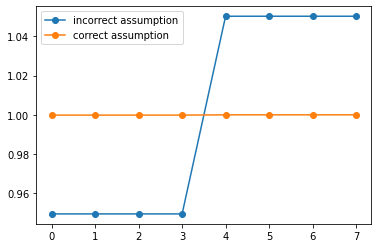

In [9]:
plt.plot(stokes_param_n[:,4], "o-", label='incorrect assumption')
plt.plot(stokes_param_c[:,4], "o-", label='correct assumption')
plt.legend()
plt.show()

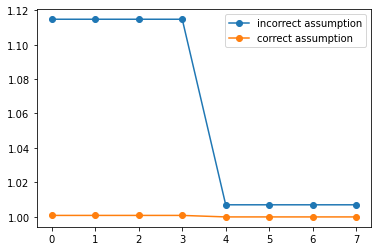

In [10]:
plt.plot(stokes_param_n[:,-1], "o-", label='incorrect assumption')
plt.plot(stokes_param_c[:,-1], "o-", label='correct assumption')
plt.legend()
plt.show()

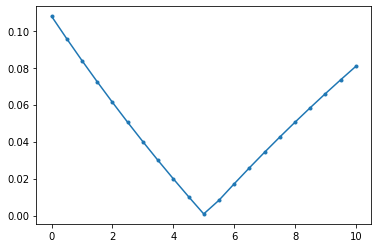

In [11]:
cost_function = get_cost_function(simulated_data)
deviation_space = np.linspace(-5*DEG, 5*DEG, 21) + derr
score = np.array([cost_function(dgamma) for dgamma in deviation_space])
plt.plot(deviation_space/DEG, score, ".-")

In [12]:
# Target probe states
Nx = 9
Ny = 9
thetas = np.linspace(0, 180, Ny)*DEG
phis = np.linspace(-180, 180, Nx)[1:]*DEG
#targets = [ks.LO, ks.HI, ks.HLO, ks.HHI, ks.CLO, ks.CHI]
targets = []
for theta in thetas:
    for phi in ([0] if (theta == 0 or theta == np.pi) else phis):
        targets.append(ks.BlochKet(theta, phi))
target_rhos = [ks.ketbra(ket, ket) for ket in targets]
xys_r = np.array([hammer_map(rho) for rho in target_rhos])


simulated_data_dense = [tuple(GenerateCurve(ket, derr)) for ket in targets]

stokes_n = np.array([ExtractStokes(x, y, 0) for x, y in simulated_data_dense])

stokes_n = np.array([ExtractStokes(x, y, 0) for x, y in simulated_data_dense])
stokes_c = np.array([ExtractStokes(x, y, derr) for x, y in simulated_data_dense])

stokes_0_n = stokes_n[:, -1]/stokes_n[:, 4]
stokes_0_c = stokes_c[:, -1]/stokes_c[:, 4]
xys_n = np.array([hammer_stokes(x[5:8]) for x in stokes_n])
xys_c = np.array([hammer_stokes(x[5:8]) for x in stokes_c])

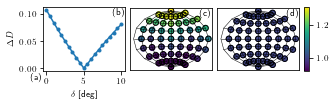

In [13]:
%matplotlib inline
# Produce plot for paper
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = 9
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['figure.figsize'] = (6, 3.5)

gridspec_kw = {'width_ratios' : [1,1,1,0.05]}
moss = """
bcdx
"""
vmin = np.min(np.concatenate([stokes_0_n, stokes_0_n]))
vmax = np.max(np.concatenate([stokes_0_n, stokes_0_c]))
figsize = (7*0.7,1.5)
fig, ax = plt.subplot_mosaic(moss, gridspec_kw = gridspec_kw, figsize=figsize)

for key in 'cd':
    hp.PlotHammerGrid(ax[key], 9, 9)
    ax[key].set_aspect(1.5)
    ax[key].set_xticks([])
    ax[key].set_yticks([])    

ax['b'].plot(deviation_space/DEG, score, ".-")
ax['b'].set_xlabel('$\delta$ [deg]')
ax['b'].set_ylabel('$\Delta D$')
#ax['b'].set_xticks([(deviation_space/DEG)[[0,13,-1]]])

im0 = ax['c'].scatter(xys_n[:,0], xys_n[:,1], s = 30, c = stokes_0_n, vmin = vmin, vmax = vmax)
ax['c'].scatter(xys_r[:,0], xys_r[:,1], s = 30, marker = 'o', edgecolors='black', facecolors='none')

im1 = ax['d'].scatter(xys_c[:,0], xys_c[:,1], s = 30, c = stokes_0_c, vmin = vmin, vmax = vmax)
ax['d'].scatter(xys_r[:,0], xys_r[:,1], s = 30, marker = 'o', edgecolors='black', facecolors='none')
fig.colorbar(im0, cax=ax['x'])
for key in ax:
    if key != 'x':
        ax[key].text(0.84, 0.86, f'({key})', transform = ax[key].transAxes)
ax['b'].text(-0.15, -0.15, '(a)', transform = ax['b'].transAxes)

plt.subplots_adjust(top=0.975,
bottom=0.382,
left=0.142,
right=0.896,
hspace=0.0,
wspace=0.08)
plt.show()